# 时间序列预测实验 Notebook

这个notebook用于：
- 快速测试和调试代码
- 探索性数据分析
- 实验新的模型和方法
- 可视化和结果分析

## 1. 环境设置

In [1]:
# 添加项目根目录到Python路径
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# 基础导入
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yaml
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# 设置matplotlib参数
%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

print("环境设置完成！")

环境设置完成！


## 2. 加载配置和初始化组件

In [3]:
# 导入项目模块
from src.data.data_loader import DataLoader
from src.models.mean_model import MeanModel
from src.models.log_model import LogModel
from src.training.trainer import Trainer
from src.evaluation.evaluator import ModelEvaluator

# 加载配置
config_path = '../config/config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("配置加载成功！")
print(f"数据集: {config['dataset']['name']}")
print(f"Mean Model - 上下文长度: {config['mean_model']['context_length']}, 预测长度: {config['mean_model']['prediction_length']}")
print(f"Log Model - 上下文长度: {config['log_model']['context_length']}, 预测长度: {config['log_model']['prediction_length']}")

配置加载成功！
数据集: ett_small_1h
Mean Model - 上下文长度: 336, 预测长度: 24
Log Model - 上下文长度: 24, 预测长度: 1


In [4]:
# 初始化组件
data_loader = DataLoader(config)
mean_model = MeanModel(config)
log_model = LogModel(config)
trainer = Trainer(config, data_loader, mean_model, log_model)
evaluator = ModelEvaluator(config)

print("组件初始化完成！")

组件初始化完成！


## 3. 数据探索

In [5]:
# 加载数据
data_loader.load_dataset()
dataset_info = data_loader.get_dataset_info()

print("数据集信息：")
for key, value in dataset_info.items():
    print(f"  {key}: {value}")

数据集信息：
  metadata: freq='1h' target=None feat_static_cat=[] feat_static_real=[] feat_dynamic_real=[] feat_dynamic_cat=[] prediction_length=24
  train_size: 14
  test_size: 14
  train_length: 17396
  test_length: 17420
  freq: h


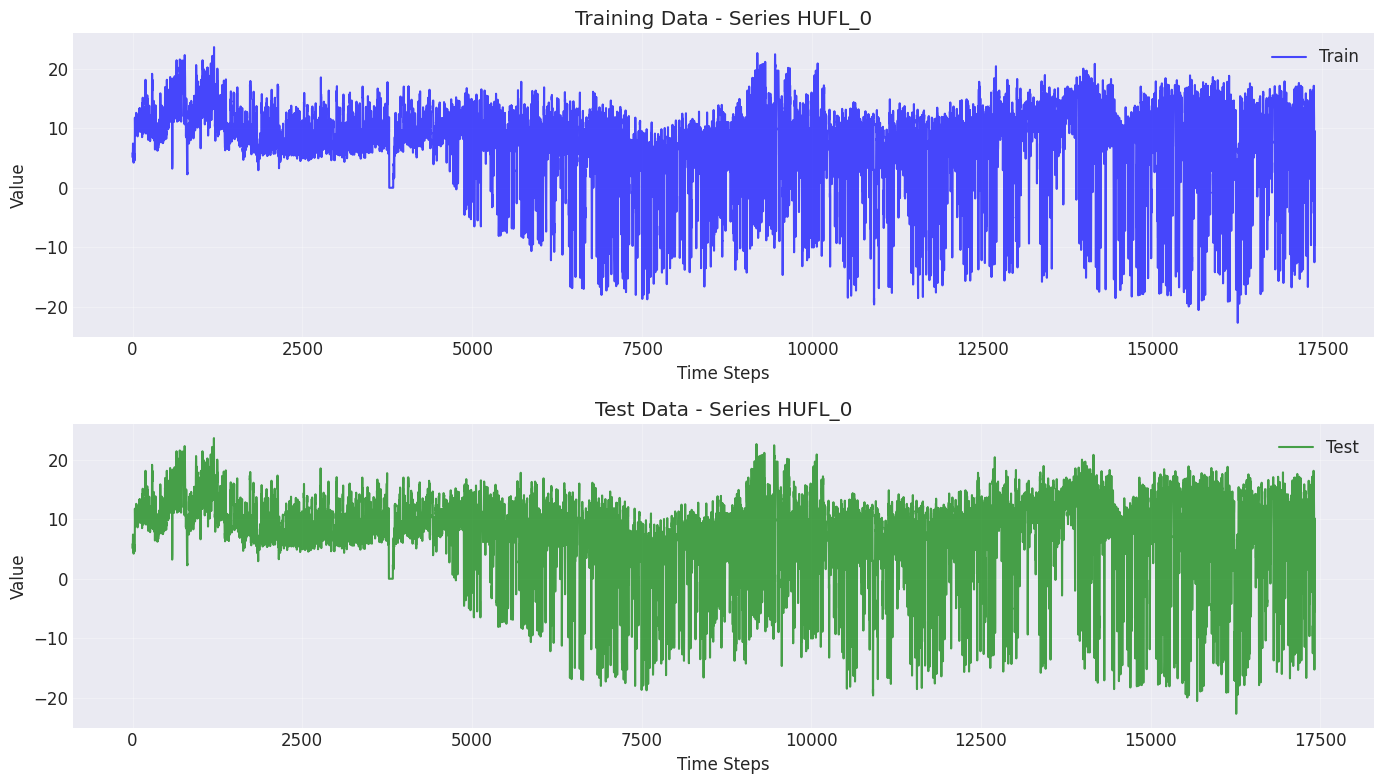

In [7]:
# 修复版本 - 直接使用数值绘图
train_values = train_entry["target"]
test_values = test_entry["target"]

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# 使用数组索引而不是时间索引
axes[0].plot(train_values, label='Train', color='blue', alpha=0.7)
axes[0].set_title(f"Training Data - Series {train_entry['item_id']}")
axes[0].set_ylabel('Value')
axes[0].set_xlabel('Time Steps')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(test_values, label='Test', color='green', alpha=0.7)
axes[1].set_title(f"Test Data - Series {test_entry['item_id']}")
axes[1].set_xlabel('Time Steps')
axes[1].set_ylabel('Value')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# 数据统计分析
train_values = [entry['target'] for entry in data_loader.train_data]
train_flat = np.concatenate(train_values)

print("训练数据统计：")
print(f"  总数据点: {len(train_flat):,}")
print(f"  均值: {np.mean(train_flat):.4f}")
print(f"  标准差: {np.std(train_flat):.4f}")
print(f"  最小值: {np.min(train_flat):.4f}")
print(f"  最大值: {np.max(train_flat):.4f}")
print(f"  25%分位数: {np.percentile(train_flat, 25):.4f}")
print(f"  50%分位数: {np.percentile(train_flat, 50):.4f}")
print(f"  75%分位数: {np.percentile(train_flat, 75):.4f}")

训练数据统计：
  总数据点: 243,544
  均值: 10.7857
  标准差: 15.8814
  最小值: -31.4620
  最大值: 107.8930
  25%分位数: 1.0050
  50%分位数: 4.8540
  75%分位数: 14.3510


## 4. Mean Model 实验

In [9]:
# 检查是否已有训练好的模型
model_exists = os.path.exists(mean_model.model_path)
print(f"Mean Model 是否已存在: {model_exists}")

if model_exists:
    print(f"模型路径: {mean_model.model_path}")
    # 加载已有模型
    mean_model.load_predictor()
    print("模型加载成功！")
else:
    print("需要训练新模型")
    # 训练模型
    mean_model.train(data_loader.train_data[:10])  # 使用部分数据快速测试
    print("模型训练完成！")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A10') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Mean Model 是否已存在: False
需要训练新模型



  | Name  | Type          | Params | Mode 
------------------------------------------------
0 | model | PatchTSTModel | 1.1 M  | train
------------------------------------------------
1.1 M     Trainable params
1.3 K     Non-trainable params
1.1 M     Total params
4.242     Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Epoch 0: |          | 50/? [00:01<00:00, 26.63it/s, v_num=0, train_loss=3.160]

Epoch 0, global step 50: 'train_loss' reached 3.16036 (best 3.16036), saving model to '/zhangyunyi/code/DualRes/univariate/notebooks/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:00<00:00, 65.60it/s, v_num=0, train_loss=2.480]

Epoch 1, global step 100: 'train_loss' reached 2.48041 (best 2.48041), saving model to '/zhangyunyi/code/DualRes/univariate/notebooks/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:00<00:00, 65.01it/s, v_num=0, train_loss=2.250]

Epoch 2, global step 150: 'train_loss' reached 2.24926 (best 2.24926), saving model to '/zhangyunyi/code/DualRes/univariate/notebooks/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:00<00:00, 64.95it/s, v_num=0, train_loss=2.170]

Epoch 3, global step 200: 'train_loss' reached 2.16737 (best 2.16737), saving model to '/zhangyunyi/code/DualRes/univariate/notebooks/lightning_logs/version_0/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:00<00:00, 64.80it/s, v_num=0, train_loss=2.160]

Epoch 4, global step 250: 'train_loss' reached 2.16430 (best 2.16430), saving model to '/zhangyunyi/code/DualRes/univariate/notebooks/lightning_logs/version_0/checkpoints/epoch=4-step=250.ckpt' as top 1


Epoch 5: |          | 50/? [00:00<00:00, 65.43it/s, v_num=0, train_loss=2.070]

Epoch 5, global step 300: 'train_loss' reached 2.06587 (best 2.06587), saving model to '/zhangyunyi/code/DualRes/univariate/notebooks/lightning_logs/version_0/checkpoints/epoch=5-step=300.ckpt' as top 1


Epoch 6: |          | 50/? [00:00<00:00, 64.43it/s, v_num=0, train_loss=2.060]

Epoch 6, global step 350: 'train_loss' reached 2.05984 (best 2.05984), saving model to '/zhangyunyi/code/DualRes/univariate/notebooks/lightning_logs/version_0/checkpoints/epoch=6-step=350.ckpt' as top 1


Epoch 7: |          | 50/? [00:00<00:00, 64.88it/s, v_num=0, train_loss=1.940]

Epoch 7, global step 400: 'train_loss' reached 1.94495 (best 1.94495), saving model to '/zhangyunyi/code/DualRes/univariate/notebooks/lightning_logs/version_0/checkpoints/epoch=7-step=400.ckpt' as top 1


Epoch 8: |          | 50/? [00:00<00:00, 65.19it/s, v_num=0, train_loss=2.030]

Epoch 8, global step 450: 'train_loss' was not in top 1


Epoch 9: |          | 50/? [00:00<00:00, 66.50it/s, v_num=0, train_loss=2.010]

Epoch 9, global step 500: 'train_loss' was not in top 1


Epoch 10: |          | 50/? [00:00<00:00, 65.37it/s, v_num=0, train_loss=1.920]

Epoch 10, global step 550: 'train_loss' reached 1.91687 (best 1.91687), saving model to '/zhangyunyi/code/DualRes/univariate/notebooks/lightning_logs/version_0/checkpoints/epoch=10-step=550.ckpt' as top 1


Epoch 11: |          | 50/? [00:00<00:00, 64.30it/s, v_num=0, train_loss=1.950]

Epoch 11, global step 600: 'train_loss' was not in top 1


Epoch 12: |          | 50/? [00:00<00:00, 64.36it/s, v_num=0, train_loss=1.990]

Epoch 12, global step 650: 'train_loss' was not in top 1


Epoch 13: |          | 50/? [00:00<00:00, 65.66it/s, v_num=0, train_loss=1.950]

Epoch 13, global step 700: 'train_loss' was not in top 1


Epoch 14: |          | 50/? [00:00<00:00, 64.59it/s, v_num=0, train_loss=1.980]

Epoch 14, global step 750: 'train_loss' was not in top 1


Epoch 15: |          | 50/? [00:00<00:00, 65.29it/s, v_num=0, train_loss=1.870]

Epoch 15, global step 800: 'train_loss' reached 1.86676 (best 1.86676), saving model to '/zhangyunyi/code/DualRes/univariate/notebooks/lightning_logs/version_0/checkpoints/epoch=15-step=800.ckpt' as top 1


Epoch 16: |          | 50/? [00:00<00:00, 64.60it/s, v_num=0, train_loss=1.950]

Epoch 16, global step 850: 'train_loss' was not in top 1


Epoch 17: |          | 50/? [00:00<00:00, 65.23it/s, v_num=0, train_loss=1.940]

Epoch 17, global step 900: 'train_loss' was not in top 1


Epoch 18: |          | 50/? [00:00<00:00, 65.83it/s, v_num=0, train_loss=1.880]

Epoch 18, global step 950: 'train_loss' was not in top 1


Epoch 19: |          | 50/? [00:00<00:00, 65.83it/s, v_num=0, train_loss=1.910]

Epoch 19, global step 1000: 'train_loss' was not in top 1


Epoch 20: |          | 50/? [00:00<00:00, 65.25it/s, v_num=0, train_loss=1.890]

Epoch 20, global step 1050: 'train_loss' was not in top 1


Epoch 21: |          | 50/? [00:00<00:00, 65.69it/s, v_num=0, train_loss=1.890]

Epoch 21, global step 1100: 'train_loss' was not in top 1


Epoch 22: |          | 50/? [00:00<00:00, 65.74it/s, v_num=0, train_loss=1.900]

Epoch 22, global step 1150: 'train_loss' was not in top 1


Epoch 23: |          | 50/? [00:00<00:00, 65.53it/s, v_num=0, train_loss=1.840]

Epoch 23, global step 1200: 'train_loss' reached 1.84479 (best 1.84479), saving model to '/zhangyunyi/code/DualRes/univariate/notebooks/lightning_logs/version_0/checkpoints/epoch=23-step=1200.ckpt' as top 1


Epoch 24: |          | 50/? [00:00<00:00, 65.44it/s, v_num=0, train_loss=1.880]

Epoch 24, global step 1250: 'train_loss' was not in top 1


Epoch 25: |          | 50/? [00:00<00:00, 65.18it/s, v_num=0, train_loss=1.820]

Epoch 25, global step 1300: 'train_loss' reached 1.82076 (best 1.82076), saving model to '/zhangyunyi/code/DualRes/univariate/notebooks/lightning_logs/version_0/checkpoints/epoch=25-step=1300.ckpt' as top 1


Epoch 26: |          | 50/? [00:00<00:00, 64.64it/s, v_num=0, train_loss=1.870]

Epoch 26, global step 1350: 'train_loss' was not in top 1


Epoch 27: |          | 50/? [00:00<00:00, 65.55it/s, v_num=0, train_loss=1.880]

Epoch 27, global step 1400: 'train_loss' was not in top 1


Epoch 28: |          | 50/? [00:00<00:00, 65.88it/s, v_num=0, train_loss=1.880]

Epoch 28, global step 1450: 'train_loss' was not in top 1


Epoch 29: |          | 50/? [00:00<00:00, 66.15it/s, v_num=0, train_loss=1.840]

Epoch 29, global step 1500: 'train_loss' was not in top 1


Epoch 30: |          | 50/? [00:00<00:00, 65.85it/s, v_num=0, train_loss=1.880]

Epoch 30, global step 1550: 'train_loss' was not in top 1


Epoch 31: |          | 50/? [00:00<00:00, 65.09it/s, v_num=0, train_loss=1.860]

Epoch 31, global step 1600: 'train_loss' was not in top 1


Epoch 32: |          | 50/? [00:00<00:00, 65.22it/s, v_num=0, train_loss=1.860]

Epoch 32, global step 1650: 'train_loss' was not in top 1


Epoch 33: |          | 50/? [00:00<00:00, 66.27it/s, v_num=0, train_loss=1.810]

Epoch 33, global step 1700: 'train_loss' reached 1.81419 (best 1.81419), saving model to '/zhangyunyi/code/DualRes/univariate/notebooks/lightning_logs/version_0/checkpoints/epoch=33-step=1700.ckpt' as top 1


Epoch 34: |          | 50/? [00:00<00:00, 65.62it/s, v_num=0, train_loss=1.840]

Epoch 34, global step 1750: 'train_loss' was not in top 1


Epoch 35: |          | 50/? [00:00<00:00, 65.98it/s, v_num=0, train_loss=1.890]

Epoch 35, global step 1800: 'train_loss' was not in top 1


Epoch 36: |          | 50/? [00:00<00:00, 65.67it/s, v_num=0, train_loss=1.820]

Epoch 36, global step 1850: 'train_loss' was not in top 1


Epoch 37: |          | 50/? [00:00<00:00, 65.13it/s, v_num=0, train_loss=1.880]

Epoch 37, global step 1900: 'train_loss' was not in top 1


Epoch 38: |          | 50/? [00:00<00:00, 65.67it/s, v_num=0, train_loss=1.810]

Epoch 38, global step 1950: 'train_loss' reached 1.80709 (best 1.80709), saving model to '/zhangyunyi/code/DualRes/univariate/notebooks/lightning_logs/version_0/checkpoints/epoch=38-step=1950.ckpt' as top 1


Epoch 39: |          | 50/? [00:00<00:00, 64.79it/s, v_num=0, train_loss=1.780]

Epoch 39, global step 2000: 'train_loss' reached 1.78031 (best 1.78031), saving model to '/zhangyunyi/code/DualRes/univariate/notebooks/lightning_logs/version_0/checkpoints/epoch=39-step=2000.ckpt' as top 1


Epoch 40: |          | 50/? [00:00<00:00, 64.26it/s, v_num=0, train_loss=1.830]

Epoch 40, global step 2050: 'train_loss' was not in top 1


Epoch 41: |          | 50/? [00:00<00:00, 65.24it/s, v_num=0, train_loss=1.840]

Epoch 41, global step 2100: 'train_loss' was not in top 1


Epoch 42: |          | 50/? [00:00<00:00, 65.37it/s, v_num=0, train_loss=1.870]

Epoch 42, global step 2150: 'train_loss' was not in top 1


Epoch 43: |          | 50/? [00:00<00:00, 66.17it/s, v_num=0, train_loss=1.900]

Epoch 43, global step 2200: 'train_loss' was not in top 1


Epoch 44: |          | 50/? [00:00<00:00, 65.94it/s, v_num=0, train_loss=1.830]

Epoch 44, global step 2250: 'train_loss' was not in top 1


Epoch 45: |          | 50/? [00:00<00:00, 66.07it/s, v_num=0, train_loss=1.810]

Epoch 45, global step 2300: 'train_loss' was not in top 1


Epoch 46: |          | 50/? [00:00<00:00, 66.41it/s, v_num=0, train_loss=1.890]

Epoch 46, global step 2350: 'train_loss' was not in top 1


Epoch 47: |          | 50/? [00:00<00:00, 65.91it/s, v_num=0, train_loss=1.860]

Epoch 47, global step 2400: 'train_loss' was not in top 1


Epoch 48: |          | 50/? [00:00<00:00, 65.39it/s, v_num=0, train_loss=1.850]

Epoch 48, global step 2450: 'train_loss' was not in top 1


Epoch 49: |          | 50/? [00:00<00:00, 66.33it/s, v_num=0, train_loss=1.860]

Epoch 49, global step 2500: 'train_loss' was not in top 1


Epoch 50: |          | 50/? [00:00<00:00, 66.23it/s, v_num=0, train_loss=1.820]

Epoch 50, global step 2550: 'train_loss' was not in top 1


Epoch 51: |          | 50/? [00:00<00:00, 65.72it/s, v_num=0, train_loss=1.840]

Epoch 51, global step 2600: 'train_loss' was not in top 1


Epoch 52: |          | 50/? [00:00<00:00, 65.51it/s, v_num=0, train_loss=1.830]

Epoch 52, global step 2650: 'train_loss' was not in top 1


Epoch 53: |          | 50/? [00:00<00:00, 64.88it/s, v_num=0, train_loss=1.780]

Epoch 53, global step 2700: 'train_loss' was not in top 1


Epoch 54: |          | 50/? [00:00<00:00, 66.92it/s, v_num=0, train_loss=1.810]

Epoch 54, global step 2750: 'train_loss' was not in top 1


Epoch 55: |          | 50/? [00:00<00:00, 65.96it/s, v_num=0, train_loss=1.900]

Epoch 55, global step 2800: 'train_loss' was not in top 1


Epoch 56: |          | 50/? [00:00<00:00, 64.98it/s, v_num=0, train_loss=1.830]

Epoch 56, global step 2850: 'train_loss' was not in top 1


Epoch 57: |          | 50/? [00:00<00:00, 63.96it/s, v_num=0, train_loss=1.820]

Epoch 57, global step 2900: 'train_loss' was not in top 1


Epoch 58: |          | 50/? [00:00<00:00, 65.46it/s, v_num=0, train_loss=1.850]

Epoch 58, global step 2950: 'train_loss' was not in top 1


Epoch 59: |          | 50/? [00:00<00:00, 66.11it/s, v_num=0, train_loss=1.800]

Epoch 59, global step 3000: 'train_loss' was not in top 1


Epoch 60: |          | 50/? [00:00<00:00, 65.22it/s, v_num=0, train_loss=1.870]

Epoch 60, global step 3050: 'train_loss' was not in top 1


Epoch 61: |          | 50/? [00:00<00:00, 66.42it/s, v_num=0, train_loss=1.830]

Epoch 61, global step 3100: 'train_loss' was not in top 1


Epoch 62: |          | 50/? [00:00<00:00, 65.95it/s, v_num=0, train_loss=1.800]

Epoch 62, global step 3150: 'train_loss' was not in top 1


Epoch 63: |          | 50/? [00:00<00:00, 66.14it/s, v_num=0, train_loss=1.840]

Epoch 63, global step 3200: 'train_loss' was not in top 1


Epoch 64: |          | 50/? [00:00<00:00, 65.82it/s, v_num=0, train_loss=1.880]

Epoch 64, global step 3250: 'train_loss' was not in top 1


Epoch 65: |          | 50/? [00:00<00:00, 65.64it/s, v_num=0, train_loss=1.780]

Epoch 65, global step 3300: 'train_loss' was not in top 1


Epoch 66: |          | 50/? [00:00<00:00, 65.46it/s, v_num=0, train_loss=1.810]

Epoch 66, global step 3350: 'train_loss' was not in top 1


Epoch 67: |          | 50/? [00:00<00:00, 66.50it/s, v_num=0, train_loss=1.800]

Epoch 67, global step 3400: 'train_loss' was not in top 1


Epoch 68: |          | 50/? [00:00<00:00, 65.18it/s, v_num=0, train_loss=1.830]

Epoch 68, global step 3450: 'train_loss' was not in top 1


Epoch 69: |          | 50/? [00:00<00:00, 65.70it/s, v_num=0, train_loss=1.770]

Epoch 69, global step 3500: 'train_loss' reached 1.77398 (best 1.77398), saving model to '/zhangyunyi/code/DualRes/univariate/notebooks/lightning_logs/version_0/checkpoints/epoch=69-step=3500.ckpt' as top 1


Epoch 70: |          | 50/? [00:00<00:00, 64.63it/s, v_num=0, train_loss=1.910]

Epoch 70, global step 3550: 'train_loss' was not in top 1


Epoch 71: |          | 50/? [00:00<00:00, 65.07it/s, v_num=0, train_loss=1.770]

Epoch 71, global step 3600: 'train_loss' reached 1.76530 (best 1.76530), saving model to '/zhangyunyi/code/DualRes/univariate/notebooks/lightning_logs/version_0/checkpoints/epoch=71-step=3600.ckpt' as top 1


Epoch 72: |          | 50/? [00:00<00:00, 66.03it/s, v_num=0, train_loss=1.800]

Epoch 72, global step 3650: 'train_loss' was not in top 1


Epoch 73: |          | 50/? [00:00<00:00, 65.02it/s, v_num=0, train_loss=1.790]

Epoch 73, global step 3700: 'train_loss' was not in top 1


Epoch 74: |          | 50/? [00:00<00:00, 65.05it/s, v_num=0, train_loss=1.860]

Epoch 74, global step 3750: 'train_loss' was not in top 1


Epoch 75: |          | 50/? [00:00<00:00, 65.22it/s, v_num=0, train_loss=1.790]

Epoch 75, global step 3800: 'train_loss' was not in top 1


Epoch 76: |          | 50/? [00:00<00:00, 66.42it/s, v_num=0, train_loss=1.820]

Epoch 76, global step 3850: 'train_loss' was not in top 1


Epoch 77: |          | 50/? [00:00<00:00, 65.41it/s, v_num=0, train_loss=1.830]

Epoch 77, global step 3900: 'train_loss' was not in top 1


Epoch 78: |          | 50/? [00:00<00:00, 66.33it/s, v_num=0, train_loss=1.820]

Epoch 78, global step 3950: 'train_loss' was not in top 1


Epoch 79: |          | 50/? [00:00<00:00, 66.17it/s, v_num=0, train_loss=1.800]

Epoch 79, global step 4000: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=80` reached.


Epoch 79: |          | 50/? [00:00<00:00, 65.49it/s, v_num=0, train_loss=1.800]
模型训练完成！


<Figure size 1200x400 with 0 Axes>

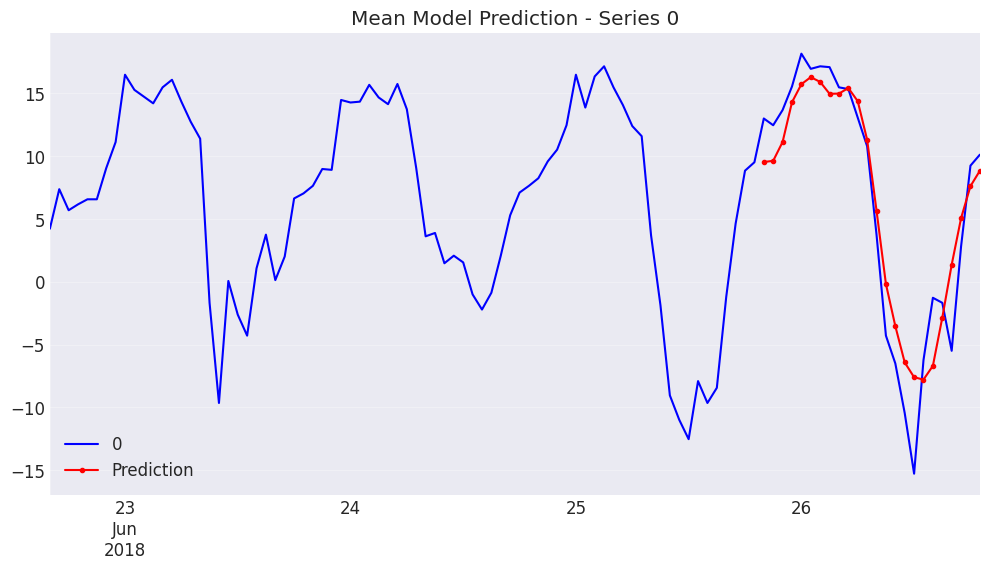

<Figure size 1200x400 with 0 Axes>

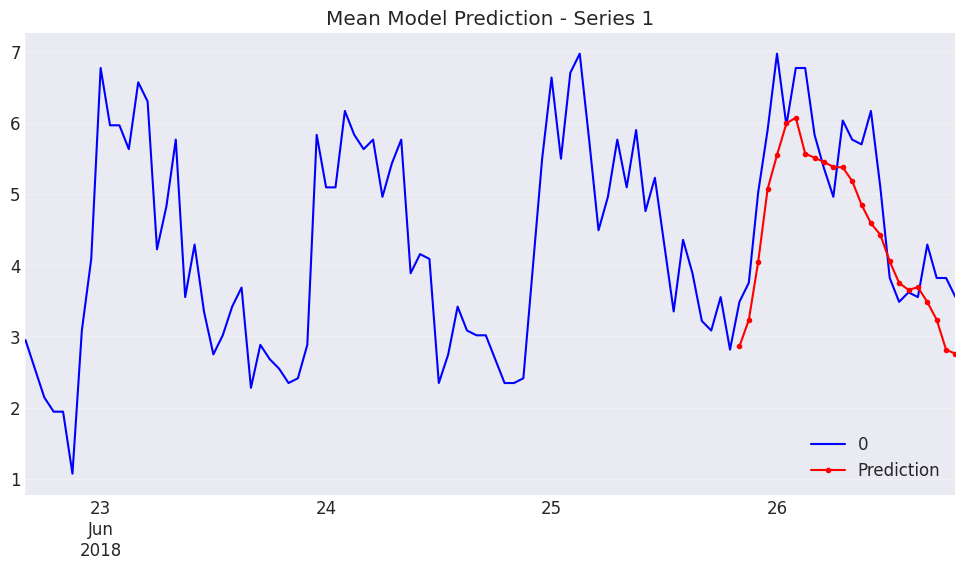

<Figure size 1200x400 with 0 Axes>

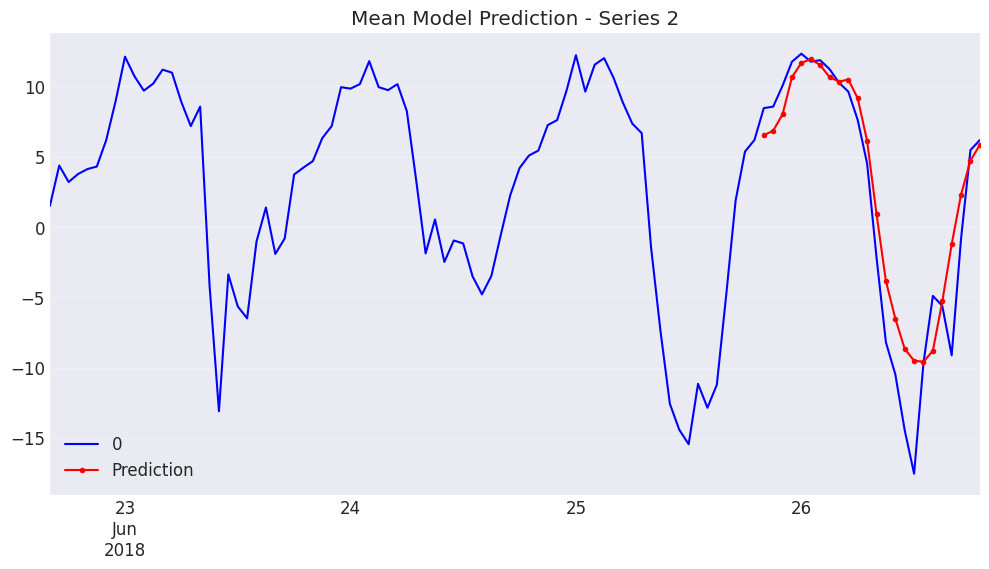

In [11]:
# 快速预测测试
from gluonts.evaluation import make_evaluation_predictions

# 使用前3个时间序列进行快速测试
test_subset = data_loader.test_data[:3]

forecasts, tss = mean_model.predict(test_subset, num_samples=1)

# 可视化预测结果
for i in range(min(3, len(forecasts))):
    plt.figure(figsize=(12, 4))
    
    # 真实值
    tss[i][-100:].plot(label='True values', color='blue')
    
    # 预测值
    pred_index = pd.date_range(
        start=forecasts[i].start_date.to_timestamp(),
        periods=len(forecasts[i].mean),
        freq=config['dataset']['freq']
    )
    forecast_series = pd.Series(forecasts[i].mean, index=pred_index)
    forecast_series.plot(label='Prediction', color='red', marker='.')
    
    plt.title(f'Mean Model Prediction - Series {i}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

## 5. 滑动窗口预测分析

In [ ]:
# 检查滑动窗口预测结果
mean_pred_path = os.path.join(config['paths']['predictions_dir'], "mean_predictions_value.npy")

if os.path.exists(mean_pred_path):
    mean_predictions = np.load(mean_pred_path, allow_pickle=True)
    print(f"滑动窗口预测已加载")
    print(f"预测形状: {[len(p) for p in mean_predictions[:5]]}")
else:
    print("生成滑动窗口预测...")
    # 使用少量数据测试
    test_data = data_loader.train_data[:5]
    mean_predictions = mean_model.sliding_window_prediction(test_data)
    print(f"预测完成！")

In [ ]:
# 分析预测误差
if 'mean_predictions' in locals():
    series_idx = 0
    true_values = data_loader.train_data[series_idx]['target']
    pred_values = mean_predictions[series_idx]
    
    # 对齐数据
    context_len = config['mean_model']['context_length']
    true_aligned = true_values[context_len:context_len+len(pred_values)]
    
    # 计算误差
    errors = np.array(true_aligned) - np.array(pred_values)
    
    # 绘制误差分布
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # 误差时序图
    axes[0].plot(errors[:200], alpha=0.7)
    axes[0].axhline(y=0, color='r', linestyle='--', alpha=0.5)
    axes[0].set_title('Prediction Errors Over Time')
    axes[0].set_xlabel('Time Step')
    axes[0].set_ylabel('Error')
    axes[0].grid(True, alpha=0.3)
    
    # 误差直方图
    axes[1].hist(errors, bins=50, edgecolor='black', alpha=0.7)
    axes[1].set_title('Error Distribution')
    axes[1].set_xlabel('Error')
    axes[1].set_ylabel('Frequency')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"误差统计：")
    print(f"  均值: {np.mean(errors):.4f}")
    print(f"  标准差: {np.std(errors):.4f}")
    print(f"  MAE: {np.mean(np.abs(errors)):.4f}")
    print(f"  RMSE: {np.sqrt(np.mean(errors**2)):.4f}")

## 6. Log Model 分析

In [ ]:
# 加载或计算log-MSE
log_mse_path = os.path.join(config['paths']['results_dir'], 
                            f"{config['dataset']['name']}_log_mse_losses.csv")

if os.path.exists(log_mse_path):
    log_mse_df = pd.read_csv(log_mse_path)
    print("Log-MSE数据加载成功")
    print(f"数据形状: {log_mse_df.shape}")
    print(f"\n前5行数据：")
    print(log_mse_df.head())
else:
    print("Log-MSE数据不存在，需要先运行完整训练流程")

In [ ]:
# 分析log-MSE的自相关性
if 'log_mse_df' in locals():
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    
    # 选择一个时间序列
    series_id = 0
    series_data = log_mse_df[log_mse_df['series_id'] == series_id]['log_mse'].values
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))
    
    # 时序图
    axes[0, 0].plot(series_data[:500], alpha=0.7)
    axes[0, 0].set_title(f'Log-MSE Time Series (Series {series_id})')
    axes[0, 0].set_xlabel('Time')
    axes[0, 0].set_ylabel('Log-MSE')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 分布图
    axes[0, 1].hist(series_data, bins=50, edgecolor='black', alpha=0.7)
    axes[0, 1].set_title('Log-MSE Distribution')
    axes[0, 1].set_xlabel('Log-MSE')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].grid(True, alpha=0.3)
    
    # ACF图
    plot_acf(series_data[:1000], lags=50, ax=axes[1, 0])
    axes[1, 0].set_title('Autocorrelation Function')
    
    # PACF图
    plot_pacf(series_data[:1000], lags=50, ax=axes[1, 1])
    axes[1, 1].set_title('Partial Autocorrelation Function')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Log-MSE统计（Series {series_id}）：")
    print(f"  均值: {np.mean(series_data):.4f}")
    print(f"  标准差: {np.std(series_data):.4f}")
    print(f"  最小值: {np.min(series_data):.4f}")
    print(f"  最大值: {np.max(series_data):.4f}")

## 7. 最终预测结果分析

In [ ]:
# 加载最终预测结果
final_res_path = os.path.join(config['paths']['predictions_dir'], "final_res_tensor.npy")

if os.path.exists(final_res_path):
    final_res = np.load(final_res_path)
    print(f"最终预测结果加载成功")
    print(f"结果形状: {final_res.shape}")
    print(f"  采样数: {final_res.shape[0]}")
    print(f"  时间序列数: {final_res.shape[1]}")
    print(f"  预测长度: {final_res.shape[2]}")
else:
    print("最终预测结果不存在，需要先运行预测流程")

In [ ]:
# 分析预测不确定性
if 'final_res' in locals():
    series_idx = 0
    samples = final_res[:, series_idx, :]
    
    # 计算统计量
    mean_pred = np.mean(samples, axis=0)
    std_pred = np.std(samples, axis=0)
    p5 = np.percentile(samples, 5, axis=0)
    p25 = np.percentile(samples, 25, axis=0)
    p75 = np.percentile(samples, 75, axis=0)
    p95 = np.percentile(samples, 95, axis=0)
    
    # 绘制不确定性
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    
    x = np.arange(len(mean_pred))
    
    # 预测和置信区间
    axes[0].plot(x, mean_pred, 'b-', label='Mean Prediction')
    axes[0].fill_between(x, p5, p95, alpha=0.2, color='blue', label='90% CI')
    axes[0].fill_between(x, p25, p75, alpha=0.3, color='blue', label='50% CI')
    axes[0].set_title(f'Prediction with Confidence Intervals (Series {series_idx})')
    axes[0].set_xlabel('Prediction Step')
    axes[0].set_ylabel('Value')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # 标准差随时间变化
    axes[1].plot(x, std_pred, 'r-', linewidth=2)
    axes[1].set_title('Prediction Uncertainty (Standard Deviation)')
    axes[1].set_xlabel('Prediction Step')
    axes[1].set_ylabel('Std Dev')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("不确定性分析：")
    print(f"  平均标准差: {np.mean(std_pred):.4f}")
    print(f"  最小标准差: {np.min(std_pred):.4f} (步骤 {np.argmin(std_pred)})")
    print(f"  最大标准差: {np.max(std_pred):.4f} (步骤 {np.argmax(std_pred)})")
    print(f"  标准差增长率: {(std_pred[-1] - std_pred[0]) / std_pred[0] * 100:.2f}%")

## 8. 实验新模型

In [ ]:
# 实验：尝试不同的模型配置
from gluonts.torch.model.d_linear import DLinearEstimator
from gluonts.torch.model.deepar import DeepAREstimator

# 创建不同的模型配置
model_configs = [
    {
        'name': 'DLinear',
        'estimator': DLinearEstimator(
            prediction_length=24,
            context_length=168,  # 一周
            trainer_kwargs={"max_epochs": 10}
        )
    },
    {
        'name': 'DeepAR',
        'estimator': DeepAREstimator(
            prediction_length=24,
            context_length=168,
            freq=config['dataset']['freq'],
            trainer_kwargs={"max_epochs": 10}
        )
    }
]

print("实验模型配置准备完成")
print(f"待测试模型: {[m['name'] for m in model_configs]}")

In [ ]:
# 快速比较不同模型（使用少量数据）
from gluonts.evaluation import Evaluator

# 使用少量数据进行快速实验
train_subset = data_loader.train_data[:10]
test_subset = data_loader.test_data[:10]

results = []
evaluator = Evaluator()

for model_config in model_configs:
    print(f"\n训练 {model_config['name']}...")
    
    # 训练
    predictor = model_config['estimator'].train(train_subset)
    
    # 预测
    from gluonts.evaluation import make_evaluation_predictions
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_subset,
        predictor=predictor,
        num_samples=10
    )
    forecasts = list(forecast_it)
    tss = list(ts_it)
    
    # 评估
    agg_metrics, _ = evaluator(tss, forecasts)
    
    results.append({
        'model': model_config['name'],
        'RMSE': agg_metrics['RMSE'],
        'MAPE': agg_metrics['MAPE'],
        'sMAPE': agg_metrics['sMAPE']
    })
    
    print(f"  RMSE: {agg_metrics['RMSE']:.4f}")
    print(f"  MAPE: {agg_metrics['MAPE']:.4f}")

# 结果对比
results_df = pd.DataFrame(results)
print("\n模型性能对比：")
print(results_df.to_string(index=False))

## 9. 自定义实验区域

In [ ]:
# 这里可以添加你自己的实验代码
# 例如：测试新的特征工程方法、新的模型架构等

print("自定义实验区域 - 在这里添加你的实验代码")

## 10. 保存实验结果

In [ ]:
# 保存实验结果
import json
from datetime import datetime

experiment_results = {
    'timestamp': datetime.now().isoformat(),
    'dataset': config['dataset']['name'],
    'mean_model_config': config['mean_model'],
    'log_model_config': config['log_model'],
    'results': {}
}

# 如果有评估结果，添加到实验记录
if 'results_df' in locals():
    experiment_results['results']['model_comparison'] = results_df.to_dict('records')

# 保存到文件
exp_dir = '../res/experiments/'
os.makedirs(exp_dir, exist_ok=True)

exp_filename = f"experiment_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json"
exp_path = os.path.join(exp_dir, exp_filename)

with open(exp_path, 'w') as f:
    json.dump(experiment_results, f, indent=2)

print(f"实验结果已保存到: {exp_path}")

## 总结

这个notebook提供了以下功能：

1. **快速测试**: 可以快速测试项目中的各个模块
2. **数据探索**: 可视化和分析数据集
3. **模型调试**: 逐步调试模型训练和预测过程
4. **结果分析**: 详细分析预测结果和不确定性
5. **实验对比**: 比较不同模型配置的性能
6. **可视化**: 生成各种图表帮助理解模型行为

使用提示：
- 修改配置文件后，重新运行第2节的代码块重新加载配置
- 可以使用部分数据进行快速实验，避免长时间等待
- 所有实验结果会自动保存，方便后续分析